In [40]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport

import os
from glob import glob
from scipy.io import loadmat

import matplotlib.pyplot as plt
plt.style.use("seaborn-deep")
import seaborn as sns

from tensorflow import keras
from keras import Model
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, GlobalAveragePooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, Input
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.applications import VGG16

import tensorflow as tf
import tensorflow_addons.losses.giou_loss as GIoU_Loss

from tqdm.auto import tqdm

from sklearn.metrics import classification_report, confusion_matrix

import cv2

import re

from skimage import io

from typing import Optional, Union, List, Tuple, ByteString, Dict

In [2]:
train_data = pd.read_csv('train.csv', dtype=str).dropna()
train_data.head()

,ruta_archivo,x1,y1,x2,y2,valencia,excitacion,dominancia
0,mscoco/images/COCO_val2014_000000562243.jpg,86,58,564,628,5,3,9
1,mscoco/images/COCO_train2014_000000288841.jpg,485,149,605,473,6,4,7
2,mscoco/images/COCO_val2014_000000558171.jpg,305,92,461,465,7,8,8
3,mscoco/images/COCO_train2014_000000369575.jpg,221,63,448,372,8,9,8
4,mscoco/images/COCO_train2014_000000213009.jpg,44,143,150,288,7,9,10


In [3]:
val_data = pd.read_csv('val.csv', dtype=str).dropna()
val_data.head()

,ruta_archivo,x1,y1,x2,y2,valencia,excitacion,dominancia
0,mscoco/images/COCO_val2014_000000020459.jpg,109,108,401,450,4,8,5
1,mscoco/images/COCO_val2014_000000033835.jpg,404,222,563,473,6,4,7
2,emodb_small/images/arhnymaeequumexga8.jpg,2,2,370,266,5,6,6
3,mscoco/images/COCO_train2014_000000535817.jpg,149,89,425,351,6,5,6
4,mscoco/images/COCO_val2014_000000187857.jpg,291,32,489,349,6,7,6


In [4]:
test_data = pd.read_csv('test.csv', dtype=str).dropna()
test_data.head()

,ruta_archivo,x1,y1,x2,y2,valencia,excitacion,dominancia
0,framesdb/images/frame_ghkq7yp0itqz0kn7.jpg,279,18,623,425,7,4,6
1,mscoco/images/COCO_train2014_000000537379.jpg,229,106,392,363,5,6,7
2,mscoco/images/COCO_train2014_000000049309.jpg,183,147,324,421,6,7,7
3,mscoco/images/COCO_train2014_000000353994.jpg,234,78,348,373,6,9,7
4,mscoco/images/COCO_train2014_000000336491.jpg,375,19,534,398,6,6,5


In [5]:
def visualize_subplot(imgs: List[np.ndarray], titles: List[str], division: Tuple[int], figsize: Tuple[int] = None, cmap: str = "gray"):
    fig: plt.Figure = plt.figure(figsize=figsize)
    if figsize:
        fig.set_figwidth(figsize[0])
        fig.set_figheight(figsize[1])

    assert len(imgs) == len(titles), "La lista de imágenes y de títulos debe ser del mismo tamaño"
    assert np.prod(division) >= len(imgs)

    for index, title in enumerate(titles):
        ax: plt.Axes = fig.add_subplot(division[0], 
                            division[1], index+1)
        ax.imshow(imgs[index], cmap=cmap)
        ax.set_title(title)
        plt.axis("off")

In [6]:
np.random.seed(27)
random_sample = np.random.choice(train_data.shape[0], 9)
imgs = []
labels = []
for i in random_sample:
    img = io.imread(train_data.loc[i,"ruta_archivo"])
    imgs.append(img)
    labels.append("Val: " + str(train_data.loc[i,"valencia"]) +
                  " Exc: " + str(train_data.loc[i,"excitacion"]) +
                  " Dom: " + str(train_data.loc[i,"dominancia"]))

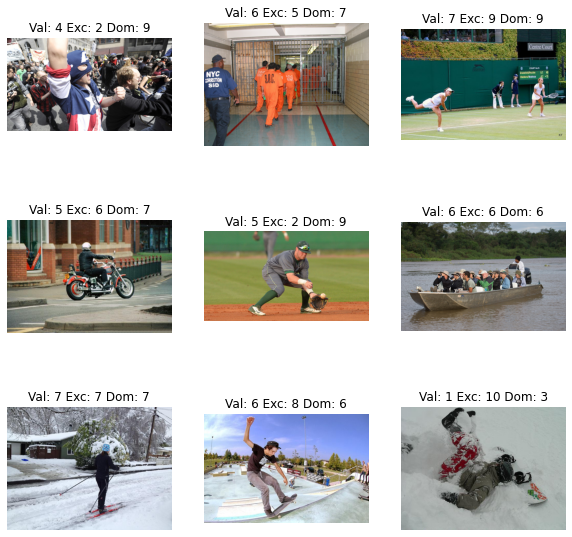

In [7]:
visualize_subplot(imgs, labels, (3, 3), (10, 10),)

In [243]:
train_list_ds_bbox = tf.data.Dataset.from_tensor_slices(train_data[['ruta_archivo','x1','y1','x2','y2']])
train_list_ds_bbox = train_list_ds_bbox.shuffle(len(train_list_ds_bbox), reshuffle_each_iteration=False)

train_list_ds_reg = tf.data.Dataset.from_tensor_slices(train_data[['ruta_archivo','valencia','excitacion','dominancia']])
train_list_ds_reg = train_list_ds_reg.shuffle(len(train_list_ds_reg), reshuffle_each_iteration=False)

In [244]:
val_list_ds_bbox = tf.data.Dataset.from_tensor_slices(val_data[['ruta_archivo','x1','y1','x2','y2']])
val_list_ds_bbox = val_list_ds_bbox.shuffle(len(val_list_ds_bbox), reshuffle_each_iteration=False)

val_list_ds_reg = tf.data.Dataset.from_tensor_slices(val_data[['ruta_archivo','valencia','excitacion','dominancia']])
val_list_ds_reg = val_list_ds_reg.shuffle(len(val_list_ds_reg), reshuffle_each_iteration=False)

In [245]:
test_list_ds_bbox = tf.data.Dataset.from_tensor_slices(test_data[['ruta_archivo','x1','y1','x2','y2']])
test_list_ds_bbox = test_list_ds_bbox.shuffle(len(test_list_ds_bbox), reshuffle_each_iteration=False)

test_list_ds_reg = tf.data.Dataset.from_tensor_slices(test_data[['ruta_archivo','valencia','excitacion','dominancia']])
test_list_ds_reg = test_list_ds_reg.shuffle(len(test_list_ds_reg), reshuffle_each_iteration=False)

In [307]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_data[['ruta_archivo','x1','y1','x2','y2','valencia','excitacion','dominancia']])
train_list_ds = train_list_ds.shuffle(len(train_list_ds), reshuffle_each_iteration=False)

val_list_ds = tf.data.Dataset.from_tensor_slices(val_data[['ruta_archivo','x1','y1','x2','y2','valencia','excitacion','dominancia']])
val_list_ds = train_list_ds.shuffle(len(val_list_ds), reshuffle_each_iteration=False)

test_list_ds = tf.data.Dataset.from_tensor_slices(test_data[['ruta_archivo','x1','y1','x2','y2','valencia','excitacion','dominancia']])
test_list_ds = train_list_ds.shuffle(len(test_list_ds), reshuffle_each_iteration=False)

In [246]:
BATCH_SIZE = 64
TRAIN_SIZE = len(train_list_ds_bbox)
VAL_SIZE = len(val_list_ds_bbox)
TEST_SIZE = len(test_list_ds_bbox)
SIZE = (200, 200)

In [247]:
@tf.function
def parse_ds_bbox_function(example_input: Optional[tf.Tensor],) -> Optional[Tuple[tf.Tensor]]:
    image = tf.io.read_file(example_input[0])
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32) / 255.

    x1 = tf.strings.to_number(example_input[1])
    y1 = tf.strings.to_number(example_input[2])
    x2 = tf.strings.to_number(example_input[3])
    y2 = tf.strings.to_number(example_input[4])

    return image, {'x1': x1, 'y1': y1, 'x2': x2, 'y2': y2}

@tf.function
def process_bbox(image: Optional[tf.Tensor], output: Optional[Dict[str,tf.Tensor]],) -> Optional[Tuple[tf.Tensor]]:
    shape = tf.shape(image)    
    image = tf.image.resize(image, SIZE)
    x_scale = 200. / tf.cast(shape[1], tf.float32)
    y_scale = 200. / tf.cast(shape[0], tf.float32)

    bbox = [tf.round(output['y1'] * y_scale),
            tf.round(output['x1'] * x_scale),
            tf.round(output['y2'] * y_scale),
            tf.round(output['x2'] * x_scale),]

    return image, bbox

In [248]:
train_ds_bbox = train_list_ds_bbox.map(parse_ds_bbox_function)
train_ds_bbox = train_ds_bbox.map(process_bbox)

val_ds_bbox = val_list_ds_bbox.map(parse_ds_bbox_function)
val_ds_bbox = val_ds_bbox.map(process_bbox)

test_ds_bbox = test_list_ds_bbox.map(parse_ds_bbox_function)
test_ds_bbox = test_ds_bbox.map(process_bbox)

In [93]:
imgs = []
for img, bbox in train_ds_bbox.take(4):
    new_img = cv2.rectangle(img.numpy(), (int(bbox[1]), int(bbox[0])), (int(bbox[3]), int(bbox[2])), (1, 0, 0), 3)
    imgs.append(new_img)

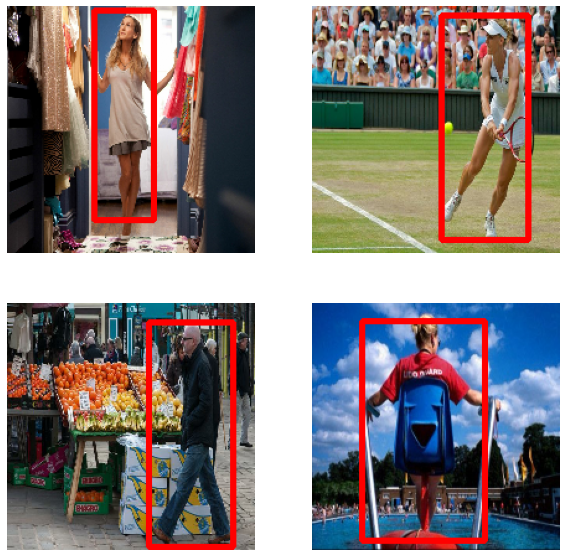

In [94]:
visualize_subplot(imgs, ["" for _ in imgs], (2, 2), (10, 10),)

In [241]:
@tf.function
def parse_ds_reg_function(example_input: Optional[tf.Tensor],) -> Optional[Tuple[tf.Tensor]]:
    image = tf.io.read_file(example_input[0])
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, SIZE)
    image = tf.cast(image, tf.float32) / 255.
    
    val = tf.strings.to_number(example_input[1])
    exc = tf.strings.to_number(example_input[2])
    dom = tf.strings.to_number(example_input[3])

    return image, [val, exc, dom]

In [249]:
train_ds_reg = train_list_ds_reg.map(parse_ds_reg_function)
val_ds_reg = val_list_ds_reg.map(parse_ds_reg_function)
test_ds_reg = test_list_ds_reg.map(parse_ds_reg_function)

In [310]:
@tf.function
def parse_ds_function(example_input: Optional[tf.Tensor],) -> Optional[Tuple[tf.Tensor]]:
    image = tf.io.read_file(example_input[0])
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32) / 255.
    
    x1 = tf.strings.to_number(example_input[1])
    y1 = tf.strings.to_number(example_input[2])
    x2 = tf.strings.to_number(example_input[3])
    y2 = tf.strings.to_number(example_input[4])
    
    shape = tf.shape(image)    
    image = tf.image.resize(image, SIZE)
    x_scale = 200. / tf.cast(shape[1], tf.float32)
    y_scale = 200. / tf.cast(shape[0], tf.float32)

    bbox = [tf.round(y1 * y_scale),
            tf.round(x1 * x_scale),
            tf.round(y2 * y_scale),
            tf.round(x2 * x_scale),]
    
    val = tf.strings.to_number(example_input[5])
    exc = tf.strings.to_number(example_input[6])
    dom = tf.strings.to_number(example_input[7])

    return image, bbox, [val, exc, dom]

In [311]:
train_ds = train_list_ds.map(parse_ds_function)
val_ds = val_list_ds.map(parse_ds_function)
test_ds = test_list_ds.map(parse_ds_function)

In [250]:
def performance(dataset: Optional[tf.data.Dataset], train: bool = True,) -> Optional[tf.data.Dataset]:
    if train:
        dataset = dataset.shuffle(512, reshuffle_each_iteration=True)
        dataset = dataset.prefetch(tf.data.AUTOTUNE)
    dataset = dataset.repeat()
    dataset = dataset.batch(BATCH_SIZE)
    return dataset

In [251]:
train_ds_bbox = performance(train_ds_bbox)
train_ds_reg  = performance(train_ds_reg)

val_ds_bbox = performance(val_ds_bbox, False)
val_ds_reg = performance(val_ds_reg, False)

test_ds_bbox = performance(test_ds_bbox, False)
test_ds_reg = performance(test_ds_reg, False)

In [312]:
train_ds = performance(train_ds)
val_ds = performance(val_ds, False)
test_ds = performance(test_ds, False)

In [41]:
vgg = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(*SIZE, 3)))
vgg.trainable = False

flatten_bbox = Flatten()(vgg.output)
dense_1_bbox = Dense(128, activation = 'relu')(flatten_bbox)
dense_2_bbox = Dense(32, activation = 'relu')(dense_1_bbox)
output_bbox = Dense(4, activation = lambda x: 200*tf.keras.activations.sigmoid(x))(dense_2_bbox)
model_bbox_base = Model(inputs = vgg.inputs, outputs = output_bbox)
model_bbox_base.summary()

58900480/58889256 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 200, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 100, 100, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 100, 100, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 100, 100, 128)     147584    
                                                              

In [255]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='min', baseline=None, restore_best_weights=False)
callbacks = [early_stopping]

In [43]:
model_bbox_base.compile(optimizer = keras.optimizers.Adam(learning_rate=0.0001), 
                 loss = GIoU_Loss)

In [44]:
params = {
    "steps_per_epoch": TRAIN_SIZE // BATCH_SIZE,
    "validation_steps": VAL_SIZE // BATCH_SIZE,
    "epochs": 250,
    "validation_data": val_ds_bbox,
    "verbose": 1,
    "callbacks": callbacks
}
history = model_bbox_base.fit(train_ds_bbox, **params)

Epoch 1/250
195/195 [==============================] - 2240s 11s/step - loss: 1.0015 - val_loss: 1.0000
Epoch 2/250
195/195 [==============================] - 2245s 12s/step - loss: 1.0000 - val_loss: 1.0000
Epoch 3/250
195/195 [==============================] - 2233s 11s/step - loss: 1.0000 - val_loss: 1.0000
Epoch 4/250
195/195 [==============================] - 2230s 11s/step - loss: 1.0000 - val_loss: 1.0000
Epoch 5/250
195/195 [==============================] - 2236s 11s/step - loss: 1.0000 - val_loss: 1.0000
Epoch 00005: early stopping


In [52]:
for X_batch, y_batch in val_ds_bbox.take(1):
    break
np.random.seed(2)
random_sample = np.random.choice(len(X_batch), 9)
X_img = X_batch.numpy()[random_sample]
y_bboxs = y_batch.numpy()[random_sample]
y_bboxs_pred = model_bbox_base.predict(X_img)

In [53]:
imgs = []
labels = []
for img, bbox, pred_bbox in zip(X_img, y_bboxs, y_bboxs_pred):
    new_img = cv2.rectangle(img, (int(bbox[1]), int(bbox[0])), (int(bbox[3]), int(bbox[2])), (1, 0, 0), 3)
    new_img = cv2.rectangle(new_img, (int(pred_bbox[1]), int(pred_bbox[0])), (int(pred_bbox[3]), int(pred_bbox[2])), (0, 0, 1), 3)
    imgs.append(new_img)
    labels.append("")

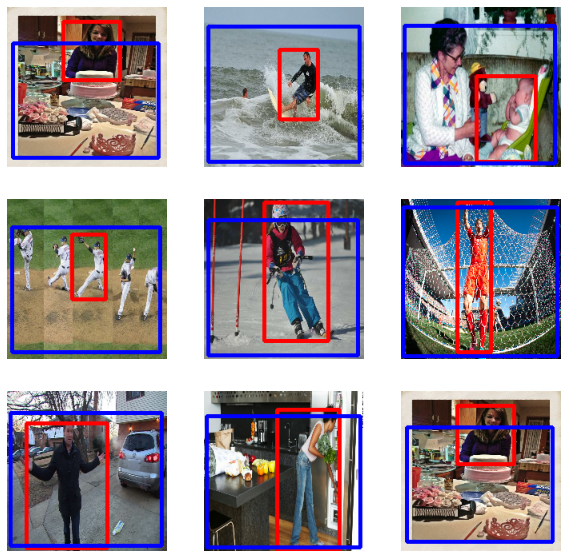

In [54]:
visualize_subplot(imgs, labels, (3, 3), (10, 10),)

In [51]:
model_bbox_base.save('./modelo_bbox_giou.h5')

In [55]:
model_bbox_base.compile(optimizer = keras.optimizers.Adam(learning_rate=0.0001), loss = 'mse')

In [57]:
params = {
    "steps_per_epoch": TRAIN_SIZE // BATCH_SIZE,
    "validation_steps": VAL_SIZE // BATCH_SIZE,
    "epochs": 50,
    "validation_data": val_ds_bbox,
    "verbose": 1,
    "callbacks": callbacks
}
history = model_bbox_base.fit(train_ds_bbox, **params)

Epoch 1/50
195/195 [==============================] - 2236s 11s/step - loss: 457.2716 - val_loss: 416.0898
Epoch 2/50
195/195 [==============================] - 2250s 12s/step - loss: 420.2852 - val_loss: 392.0949
Epoch 3/50
195/195 [==============================] - 2236s 11s/step - loss: 391.3178 - val_loss: 356.8856
Epoch 4/50
195/195 [==============================] - 2239s 12s/step - loss: 360.8013 - val_loss: 323.9194
Epoch 5/50
195/195 [==============================] - 2233s 11s/step - loss: 334.7567 - val_loss: 297.7755
Epoch 6/50
195/195 [==============================] - 2236s 11s/step - loss: 303.4906 - val_loss: 274.0227
Epoch 7/50
195/195 [==============================] - 2257s 12s/step - loss: 275.7411 - val_loss: 254.5435
Epoch 8/50
195/195 [==============================] - 2319s 12s/step - loss: 254.6010 - val_loss: 236.4429
Epoch 9/50
195/195 [==============================] - 2295s 12s/step - loss: 230.6547 - val_loss: 217.5581
Epoch 10/50
195/195 [================

In [105]:
for X_batch, y_batch in val_ds_bbox.take(1):
    break
np.random.seed(1)
random_sample = np.random.choice(len(X_batch), 9)
X_img = X_batch.numpy()[random_sample]
y_bboxs = y_batch.numpy()[random_sample]
y_bboxs_pred = model_bbox_base.predict(X_img)

In [106]:
imgs = []
labels = []
for img, bbox, pred_bbox in zip(X_img, y_bboxs, y_bboxs_pred):
    new_img = cv2.rectangle(img, (int(bbox[1]), int(bbox[0])), (int(bbox[3]), int(bbox[2])), (1, 0, 0), 3)
    new_img = cv2.rectangle(new_img, (int(pred_bbox[1]), int(pred_bbox[0])), (int(pred_bbox[3]), int(pred_bbox[2])), (0, 0, 1), 3)
    imgs.append(new_img)
    labels.append("")

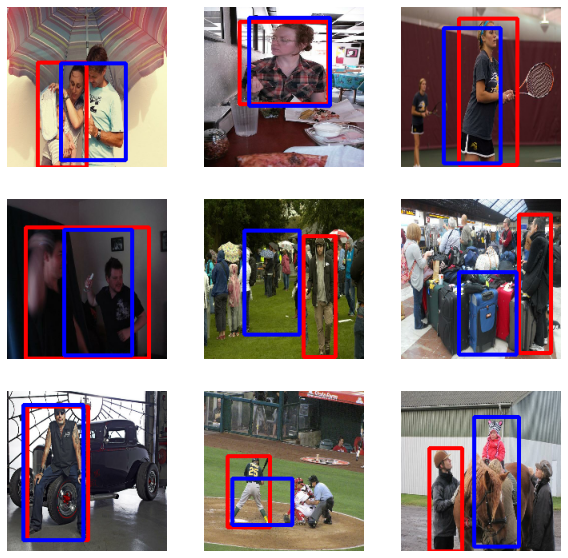

In [107]:
visualize_subplot(imgs, labels, (3, 3), (10, 10),)

In [61]:
model_bbox_base.save('./modelo_bbox_mse.h5')

In [82]:
model_bbox_base.save_weights('modelo_bbox_mse_weights', save_format='tf')

In [258]:
inception = keras.applications.InceptionV3(include_top=False, weights="imagenet", input_shape=(*SIZE, 3),)
inception.trainable = False

flatten_emo = Flatten()(inception.output)
dense_1_emo = Dense(128, activation = 'relu')(flatten_emo)
dense_2_emo = Dense(32, activation = 'relu')(dense_1_emo)
output_emo = Dense(3, activation = lambda x: 10*tf.keras.activations.sigmoid(x))(dense_2_emo)
model_reg_base = Model(inputs = inception.inputs, outputs = output_emo)

model_reg_base.summary()

Model: "model_35"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_36 (InputLayer)          [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_294 (Conv2D)            (None, 99, 99, 32)   864         ['input_36[0][0]']               
                                                                                                  
 batch_normalization_282 (Batch  (None, 99, 99, 32)  96          ['conv2d_294[0][0]']             
 Normalization)                                                                                   
                                                                                           

In [259]:
model_reg_base.compile(optimizer = keras.optimizers.Adam(learning_rate=0.0001), 
                 loss = 'mse')

In [260]:
params = {
    "steps_per_epoch": TRAIN_SIZE // BATCH_SIZE,
    "validation_steps": VAL_SIZE // BATCH_SIZE,
    "epochs": 50,
    "validation_data": val_ds_reg,
    "verbose": 1,
    "callbacks": callbacks
}
history = model_reg_base.fit(train_ds_reg, **params)

Epoch 1/50
195/195 [==============================] - 302s 2s/step - loss: 4.0791 - val_loss: 1.7025
Epoch 2/50
195/195 [==============================] - 297s 2s/step - loss: 3.0234 - val_loss: 1.5888
Epoch 3/50
195/195 [==============================] - 297s 2s/step - loss: 2.7504 - val_loss: 1.5736
Epoch 4/50
195/195 [==============================] - 298s 2s/step - loss: 2.4982 - val_loss: 1.6252
Epoch 5/50
195/195 [==============================] - 298s 2s/step - loss: 2.3406 - val_loss: 1.5536
Epoch 6/50
195/195 [==============================] - 298s 2s/step - loss: 2.1825 - val_loss: 1.5145
Epoch 7/50
195/195 [==============================] - 297s 2s/step - loss: 2.0612 - val_loss: 1.5321
Epoch 8/50
195/195 [==============================] - 298s 2s/step - loss: 1.9315 - val_loss: 1.6471
Epoch 9/50
195/195 [==============================] - 298s 2s/step - loss: 1.8101 - val_loss: 1.7404
Epoch 00009: early stopping


In [264]:
model_reg_base.save_weights('modelo_reg_mse_weights', save_format='tf')

In [319]:
for X_batch, y_batch_bbox, y_batch_reg in train_ds.take(1):
    break
np.random.seed(7)
random_sample = np.random.choice(len(X_batch), 9)
X_img = X_batch.numpy()[random_sample]
y_reg = y_batch_reg.numpy()[random_sample]
y_reg_pred = model_reg_base.predict(X_img)
y_bboxs = y_batch_bbox.numpy()[random_sample]
y_bboxs_pred = model_bbox_base.predict(X_img)

In [320]:
imgs = []
labels = []
for img, reg, reg_pred, bbox, pred_bbox in zip(X_img, y_reg, y_reg_pred, y_bboxs, y_bboxs_pred):
    new_img = cv2.rectangle(img, (int(bbox[1]), int(bbox[0])), (int(bbox[3]), int(bbox[2])), (1, 0, 0), 3)
    new_img = cv2.rectangle(new_img, (int(pred_bbox[1]), int(pred_bbox[0])), (int(pred_bbox[3]), int(pred_bbox[2])), (0, 0, 1), 3)
    str_real = "Real: Val: " + str(round(reg[0])) + "; Exc: " + str(round(reg[1])) + "; Dom: " + str(round(reg[2]))
    str_pred = "\nPred: Val: " + str(round(pred_reg[0])) + "; Exc: " + str(round(pred_reg[1])) + "; Dom: " + str(round(pred_reg[2]))
    imgs.append(new_img)
    labels.append(str_real + str_pred)

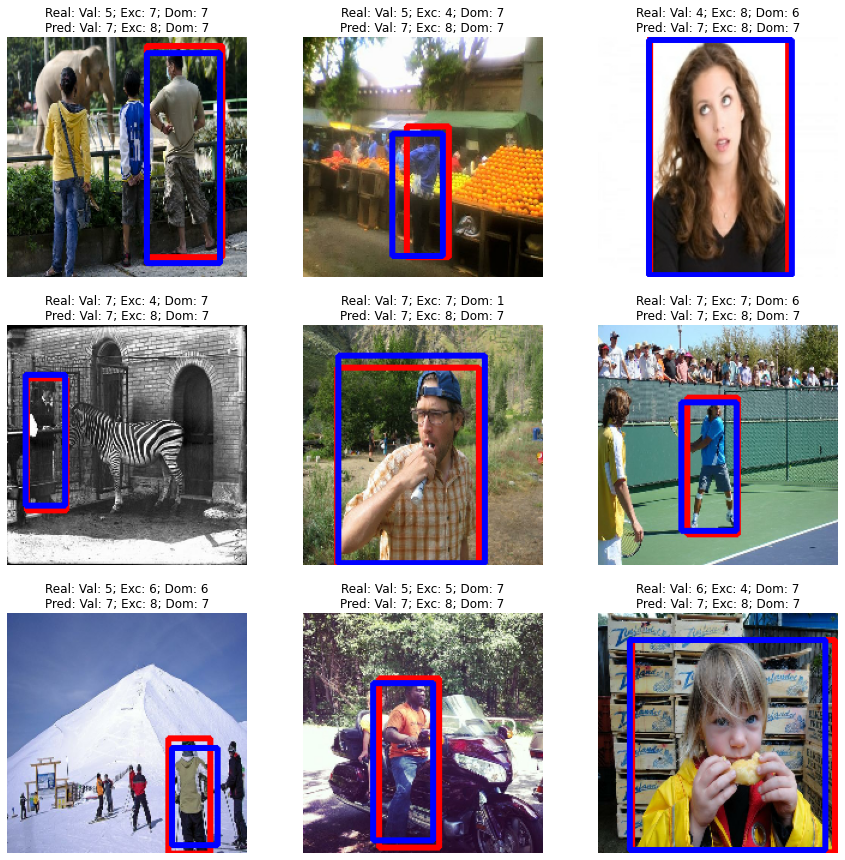

In [321]:
visualize_subplot(imgs, labels, (3, 3), (15, 15),)

## Saving bboxes images

In [238]:
for X_batch, y_batch in train_ds_reg.take(TRAIN_SIZE):
    for img, output in zip(X_batch, y_batch):
        print(output)
        break
    break

tf.Tensor([ 72.  69. 248.], shape=(3,), dtype=float32)


In [211]:
model_bbox_base.compile(optimizer = keras.optimizers.Adam(learning_rate=0.0001), loss = 'mse')

In [212]:
params = {
    "steps_per_epoch": TRAIN_SIZE // BATCH_SIZE,
    "validation_steps": VAL_SIZE // BATCH_SIZE,
    "epochs": 50,
    "validation_data": val_ds_reg_cut,
    "verbose": 1,
    "callbacks": callbacks
}
history = model_reg_base.fit(train_ds_reg_cut, **params)

Epoch 1/50
 12/195 [>.............................] - ETA: 1:08:52 - loss: 158979.0000

KeyboardInterrupt: 